In [12]:
import numpy as np
from astropy import units as u
import tqdm
from scipy.stats import expon
import matplotlib.pyplot as plt
import seaborn
from astropy.visualization import quantity_support
V = 1e6 * u.m**3 # coalescence cell volume
n0 = 100 / u.cm**3 # initial number density of droplets
N = 10000   # initial number of super-droplets
multiplicity = (n0*V/N * np.ones(N)).astype(int).si
multiplicity[0]

<Quantity 1.e+10>

In [13]:
dt = 0.01 * u.s

In [14]:
r_average = 30.531 * u.micron
r_average

<Quantity 30.531 micron>

In [15]:
v_average = 4 * np.pi / 3 * r_average ** 3
v_average

<Quantity 119209.72798966 micron3>

In [16]:
exponential_distribution = expon(0, v_average.to(u.m**3))
volumes = exponential_distribution.rvs(int(1e4)) * u.m**3

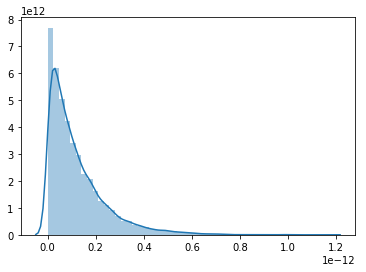

In [17]:
with quantity_support():
    seaborn.distplot(volumes)

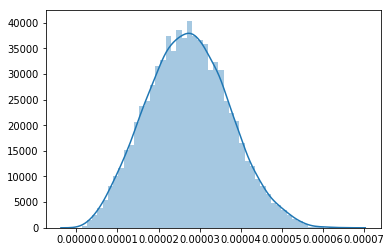

In [18]:
radii = (3 * volumes / (4 * np.pi))**(1/3)
with quantity_support():
    seaborn.distplot(radii)

In [24]:
np.sum(radii < 40*u.micrometer) / len(radii)

0.8946

In [25]:
np.sum(radii > 600*u.micrometer) / len(radii)

0.0

In [31]:
def terminal_velocity(radius, alpha, beta):
    """ Rogers (1976), page 2 of Terminal Velocities of Droplets and Crystals: Power Laws with Continuous Parameters over the Size Spectrum
    """
    k1 = 1.19e6 / u.cm / u.s
    k2 = 8e3 / u.s
    indices_turbulent = radius > 40 * u.micrometer
    velocities = u.Quantity(np.empty(radius.size), unit=u.m/u.s)
    velocities[indices_turbulent] = k1 * radius[indices_turbulent] ** 2
    velocities[~indices_turbulent] = k2 * radius[~indices_turbulent]
    
    return velocities

In [32]:
volumes = exponential_distribution.rvs(N) * u.m**3
radii = (3 * volumes / (4 * np.pi))**(1/3)
E_jk = 1 # TODO
terminal_velocities = terminal_velocity(radii, alpha=1, beta=1) # TODO

4. Develop a subroutine to evaluate the collision probabilities. First in the
primitive model (i.e., Pjk in the system of real droplets), and then in the
system of super-droplets (i.e, Pjk(SD) for sampling over the whole set of col-
liding pairs and Pjk(SD,LS)
 for the linear sampling).
 
$$P_{jk} = E_{jk} \pi (r_j + r_k)^2 |u(r_j) - u(r_k)| \Delta t / V $$

In [33]:
# P = u.Quantity(np.empty((N, N)))
# for j in tqdm.tqdm_notebook(range(N)):
#     for k in range(j, N):
#         P[j,k] = P[k, j] = E_jk * np.pi * (radii[j] + radii[k])**2 * \
#                      np.abs(terminal_velocities[j] - terminal_velocities[k]) * dt / V
# P

# %%timeit
# for j in range(N):
#     for k in range(j, N):
#         P[j,k] = P[k, j] = E_jk * np.pi * (radii[j] + radii[k])**2 * \
#                      np.abs(terminal_velocities[j] - terminal_velocities[k]) * dt / V
# np.testing.assert_allclose(P, P_numpy)

#  ![Whoa.](https://media1.tenor.com/images/bd2f86e9569a3809c044cbcb250990b2/tenor.gif?itemid=12028915)

In [34]:
P_numpy = E_jk * np.pi * (radii.reshape(N, 1) + radii.reshape(1, N))**2 * dt / V * \
                 np.abs(terminal_velocities.reshape(N, 1) - terminal_velocities.reshape(1, N))

In [35]:
%%timeit
P_numpy = E_jk * np.pi * (radii.reshape(N, 1) + radii.reshape(1, N))**2 * dt / V * \
                 np.abs(terminal_velocities.reshape(N, 1) - terminal_velocities.reshape(1, N))

1.92 s ± 180 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
pairs = np.random.permutation(range(N)).reshape(int(N/2), 2)
pairs[:5]

array([[ 626, 7350],
       [8649, 9793],
       [9691, 4637],
       [6398,  491],
       [2403, 1872]])

In [37]:
j_indices, k_indices = pairs.T
P_pairs = E_jk * np.pi * (radii[j_indices] + radii[k_indices])**2 * dt / V * \
                 np.abs(terminal_velocities[j_indices] - terminal_velocities[k_indices])

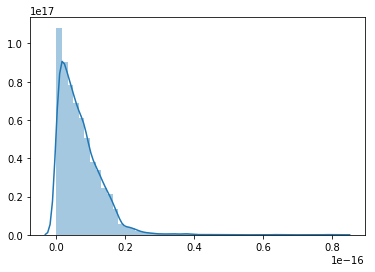

In [38]:
seaborn.distplot(P_pairs)

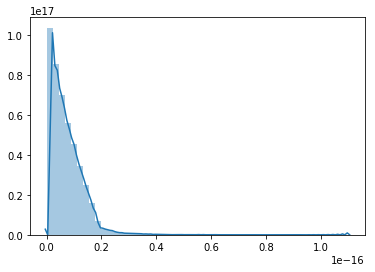

In [39]:
seaborn.distplot(P_numpy.flatten())

In [40]:
def pairwise_probabilities(radii, alpha, beta, dt, V, E_jk):
    terminal_velocities = terminal_velocity(radii, alpha, beta)
    N = radii.size
    pairs = np.random.permutation(range(N)).reshape(int(N/2), 2)
    j_indices, k_indices = pairs.T
    P_pairs = E_jk * np.pi * (radii[j_indices] + radii[k_indices])**2 * dt / V * \
                     np.abs(terminal_velocities[j_indices] - terminal_velocities[k_indices])
    return j_indices, k_indices, P_pairs

In [41]:
%%timeit
pairwise_probabilities(radii, 1, 1, dt=dt, V=V, E_jk=E_jk)
# pairs = np.random.permutation(range(N)).reshape(int(N/2), 2)
# j_indices, k_indices = pairs.T
# P_pairs = E_jk * np.pi * (radii[j_indices] + radii[k_indices])**2 * dt / V * \
#                  np.abs(terminal_velocities[j_indices] - terminal_velocities[k_indices])

3.12 ms ± 406 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


5. Develop a subroutine to compute the change of the super-droplets state after
a coalescence event. How should we proceed when ξj = ξk = 1 (what
results in ξj 0 = 0 and ξk 0 = 1 after coalescence)?

In [42]:
j_indices, k_indices, P_pairs = pairwise_probabilities(radii, alpha=1, beta=1, dt=dt, V=V, E_jk=1e10)
P_pairs

<Quantity [3.96614627e-08, 4.99675224e-08, 6.14677742e-08, ...,
           4.58519243e-08, 3.58924358e-08, 2.92390314e-09]>

In [45]:
from math import floor
def apply_coalescence(multiplicity_j, radius_j, multiplicity_k, radius_k):
#     if multiplicity_j == multiplicity_k == 1:
#         raise NotImplementedError("Remove j from simulation") # TODO
#         new_multiplicity_j = new_radius_j = np.nan
#         new_
#     assert isinstance(multiplicity_j, int) & isinstance(multiplicity_k, int)
    if multiplicity_j == multiplicity_k:
        new_multiplicity_j = int(floor(multiplicity_j/2))
        new_multiplicity_k = multiplicity_j - new_multiplicity_j
        new_radius_j = new_radius_k = (radius_j**3 + radius_k**3)**(1/3)
    elif multiplicity_j > multiplicity_k:
        new_multiplicity_j = multiplicity_j - multiplicity_k
        new_multiplicity_k = multiplicity_k
        new_radius_j = radius_j
        new_radius_k = (radius_j **3 + radius_k**3)**(1/3)
    elif multiplicity_j < multiplicity_k:
        new_multiplicity_k = multiplicity_k - multiplicity_j
        new_multiplicity_j = multiplicity_j
        new_radius_k = radius_k
        new_radius_j = (radius_k **3 + radius_j**3)**(1/3)
    else:
        raise ValueError("wat")
    return new_multiplicity_j, new_radius_j, new_multiplicity_k, new_radius_k

def vector_coalescence(multiplicity, radii, j_indices, k_indices):
    # TODO try np.take
    multiplicity_j = multiplicity[j_indices]
    multiplicity_k = multiplicity[k_indices]
    equals = multiplicity_j == multiplicity_k
#     multiplicity[equals &]

In [46]:
np.random.seed(0)
beta = 1
alpha = 1e12
indices_j, indices_k, P_jk = pairwise_probabilities(radii, alpha, beta, dt, V, 1e6)
coalesced = P_jk > 5e-3

In [48]:
# coalesced_pairs = np.vstack((indices_j[coalesced], indices_k[coalesced]))
# multiplicity_j, multiplicity_k = np.take(multiplicity, coalesced_pairs)
# radius_j, radius_k = np.take(radii, coalesced_pairs)

# indices_equal = multiplicity_j == multiplicity_k

# # equal case
# new_multiplicity_j = np.floor(multiplicity_j / 2).astype(int)
# new_multiplicity_k = multiplicity_j - new_multiplicity_j
# new_radius_j = new_radius_k = (radius_j**3 + radius_k**3)**(1/3)

# # j > k
# indices_j_larger = multiplicity_j > multiplicity_k
# new_multiplicity_j = multiplicity_j[]
# indices_k_larger = multiplicity_j < multiplicity_k

# clear oout

In [49]:
apply_coalescence(1, 1, 1, 1)

(0, 1.2599210498948732, 1, 1.2599210498948732)

In [50]:
apply_coalescence(10, 10, 10, 10)

(5, 12.59921049894873, 5, 12.59921049894873)

In [51]:
apply_coalescence(10, 10, 20, 20)

(10, 20.800838230519037, 10, 20)

In [52]:
apply_coalescence(20, 20, 10, 10)

(10, 20, 10, 20.800838230519037)

In [53]:
def droplet_number_density(multiplicity, V):
    return np.sum(multiplicity) / V

def precipitation_rate(multiplicity, radius, V, alpha, beta):
    return np.pi / 6.0 / V * np.sum(multiplicity * (2 * radius)**3 * terminal_velocity(radius, alpha, beta))

def radar_reflectivity_factor(multiplicity, radius, V, z0=1*u.mm**6*u.mm**-3):
    z = np.sum(multiplicity * (2 * radius)**6) / V
    Z = 10 * np.log10(z/z0)
    return Z

In [54]:
droplet_number_density(multiplicity, V)

<Quantity 99999999.99999999 1 / m3>

In [55]:
precipitation_rate(multiplicity, radii, V, alpha=1, beta=1)

<Quantity 3.05552311e-06 m / s>

In [56]:
radar_reflectivity_factor(multiplicity, radii, V)

<Quantity -79.70724142>

In [57]:
def simulation(multiplicity, radii, dt, NT, V, E_jk, alpha=1, beta=1):
    tables = [{"multiplicity":multiplicity, "radii":radii}]
    multiplicity = multiplicity.copy()
    radii = radii.copy()
    diagnostics = []
    for i in tqdm.tqdm_notebook(range(NT)):
        N = radii.size # this can change dynamically
        indices_j, indices_k, P_jk = pairwise_probabilities(radii, alpha, beta, dt, V, E_jk)
        multiplicities_j = multiplicity[indices_j]
        multiplicities_k = multiplicity[indices_k]
        max_multiplicities = np.max(np.vstack((multiplicities_j, multiplicities_k)), axis=0)
        fixed_probabilities = max_multiplicities * P_jk 
        random_numbers = np.random.random(fixed_probabilities.size)
        coalescing_pairs = fixed_probabilities > random_numbers
        num_coalesced = coalescing_pairs.sum()
        for j, k in zip(indices_j[coalescing_pairs], indices_k[coalescing_pairs]): # TODO rewrite this in array style
            multiplicity[j], radii[j], multiplicity[k], radii[k] = apply_coalescence(multiplicity[j], radii[j], multiplicity[k], radii[k])
        removed_particles = multiplicity == 0
        multiplicity = multiplicity[~removed_particles]
        radii = radii[~removed_particles]
        diagnostics.append({
            "N_superdroplets":N,
            "num_coalesced":num_coalesced,
            "mean_probability":fixed_probabilities.mean(),
            "droplet_number_density":droplet_number_density(multiplicity, V).si.value,
            "precipitation_rate":precipitation_rate(multiplicity, radii, V, alpha, beta).si.value,
            "radar_reflectivity_factor":radar_reflectivity_factor(multiplicity,radii,V).si.value,
        })
        tables.append({
            "multiplicity":multiplicity.copy(),
            "radii": radii.copy()
        })
    return diagnostics, tables

diagnostics, tables = simulation(multiplicity, radii, dt, int(5e1), V, E_jk=1e9, alpha=1, beta=1)
import pandas as pd
df = pd.DataFrame(diagnostics)
for col in df.columns:
    try:
        df.plot(y=col)
    except TypeError:
        print(f"Failed to print for {col}")
df.tail()

ValueError: cannot reshape array of size 9999 into shape (4999,2)

In [52]:
%load_ext line_profiler

In [54]:
%lprun -f simulation simulation(multiplicity, radii, dt, int(5e1), V, E_jk=1e9, alpha=1, beta=1)

Timer unit: 1e-06 s

Total time: 126.737 s
File: <ipython-input-53-15a7c4124508>
Function: simulation at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def simulation(multiplicity, radii, dt, NT, V, E_jk, alpha=1, beta=1):
     2         1          2.0      2.0      0.0      tables = [{"multiplicity":multiplicity, "radii":radii}]
     3         1         31.0     31.0      0.0      multiplicity = multiplicity.copy()
     4         1         13.0     13.0      0.0      radii = radii.copy()
     5         1          1.0      1.0      0.0      diagnostics = []
     6       501     939536.0   1875.3      0.7      for i in tqdm.tqdm_notebook(range(NT)):
     7       500       1921.0      3.8      0.0          N = radii.size # this can change dynamically
     8       500    2496640.0   4993.3      2.0          indices_j, indices_k, P_jk = pairwise_probabilities(radii, alpha, beta, dt, V, E_jk)
     9       500      2910

In [55]:
def simulation(multiplicity, radii, dt, NT, V, E_jk, alpha=1, beta=1):
    tables = [{"multiplicity":multiplicity, "radii":radii}]
    multiplicity = multiplicity.copy()
    radii = radii.copy()
    diagnostics = []
    for i in tqdm.tqdm_notebook(range(NT)):
        N = radii.size # this can change dynamically
        indices_j, indices_k, P_jk = pairwise_probabilities(radii, alpha, beta, dt, V, E_jk)
        multiplicities_j = multiplicity[indices_j]
        multiplicities_k = multiplicity[indices_k]
        max_multiplicities = np.max(np.vstack((multiplicities_j, multiplicities_k)), axis=0)
        fixed_probabilities = max_multiplicities * P_jk 
        random_numbers = np.random.random(fixed_probabilities.size)
        coalescing_pairs = fixed_probabilities > random_numbers
        num_coalesced = coalescing_pairs.sum()
        for j, k in zip(indices_j[coalescing_pairs], indices_k[coalescing_pairs]): # TODO rewrite this in array style
            multiplicity[j], radii[j], multiplicity[k], radii[k] = apply_coalescence(multiplicity[j], radii[j], multiplicity[k], radii[k])
        removed_particles = multiplicity == 0
        multiplicity = multiplicity[~removed_particles]
        radii = radii[~removed_particles]
        diagnostics.append({
            "N_superdroplets":N,
            "num_coalesced":num_coalesced,
            "mean_probability":fixed_probabilities.mean(),
            "droplet_number_density":droplet_number_density(multiplicity, V).si.value,
            "precipitation_rate":precipitation_rate(multiplicity, radii, V, alpha, beta).si.value,
            "radar_reflectivity_factor":radar_reflectivity_factor(multiplicity,radii,V).si.value,
        })
        tables.append({
            "multiplicity":multiplicity.copy(),
            "radii": radii.copy()
        })
    return diagnostics, tables

diagnostics, tables = simulation(multiplicity, radii, dt, int(5e2), V, E_jk=1e9, alpha=1, beta=1)
import pandas as pd
df = pd.DataFrame(diagnostics)
df.plot(y="precipitation_rate")
df.tail()
# df.plot(y="mean_probability")

    100% |████████████████████████████████| 40kB 415kB/s 
  Running setup.py bdist_wheel for memory-profiler ... done
  Stored in directory: /home/dominik/.cache/pip/wheels/f0/ff/63/fdbff3f1e1b76ad4eae491dd5b190902906b093e93eb86dd5a
Successfully built memory-profiler
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# %load_ext memory_profiler
# %memit sum_of_lists(1000000)